In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report
import math
import numpy as np

from sklearn.preprocessing import StandardScaler
#from yellowbrick.regressor import ResidualsPlot

##  Carrega dados

In [2]:
df = pd.read_csv("data/apartamentos_completo.csv")

df = df.drop(['Unnamed: 0'],axis=1)
df.reset_index(inplace=True,drop=True)
print(df.shape)
df.head()

(30748, 17)


,nome,valor_venda,url,condominio,IPTU,lat,long,area_total,area_util,banheiros,vagas,quartos,suites,idade,endereco,bairro,idade_anuncio
0,Tower duplex 90m2,550000,https://www.wimoveis.com.br/propriedades/tower...,R$ 730,R$ 690,-15.842635250484830,-48.024645807548495,89m²,89m²,3.0,2.0,2.0,2.0,6,"Qd 206, Aguas Sul, Águas Claras",", Aguas Sul, Águas Claras",52
1,SELECTION 36,2150000,https://www.wimoveis.com.br/propriedades/selec...,NaN,NaN,-15.742129999999999,-47.910919999999997,224m²,224m²,6.0,3.0,4.0,4.0,4,"Quadra SQNW 110, Noroeste, Brasília",", Noroeste, Brasília",6
2,Elevador + Apartamento de 3 Quartos + Excelent...,420000,https://www.wimoveis.com.br/propriedades/eleva...,NaN,NaN,-15.739203900000000,-47.902473900000020,NaN,65m²,2.0,0.0,3.0,0.0,NaN,SCRN 706/707 BLOCO F - COMPLETO ARMÁRIOS- EXCE...,", Asa Norte, Brasília",9
3,"01, 02 QUARTOS E LOJA COMERCIAL - MEET NOROESTE",332420,https://www.wimoveis.com.br/propriedades/01-02...,NaN,NaN,-15.748856500000000,-47.896520000000010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14
4,Elegance Park Sul de 03 Suítes,1333800,https://www.wimoveis.com.br/propriedades/elega...,NaN,NaN,-15.827143900000000,-47.952883600000010,117m²,117m²,5.0,2.0,3.0,3.0,1,"Sgcv 23, Park Sul, Brasília",", Park Sul, Brasília",8


In [3]:
df.dtypes

nome              object
valor_venda        int64
url               object
condominio        object
IPTU              object
lat               object
long              object
area_total        object
area_util         object
banheiros        float64
vagas            float64
quartos          float64
suites           float64
idade             object
endereco          object
bairro            object
idade_anuncio     object
dtype: object

### Dropa imoveis que não tem latitude, longitude e área útil

In [4]:
df.dropna(subset=['lat', 'long','area_util','bairro'],inplace=True)
df.shape

(25493, 17)

### Quantidade de valores nulos por coluna

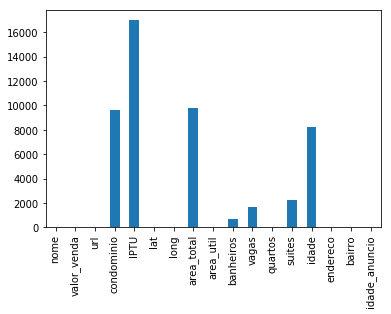

In [5]:
df.isna().sum().plot.bar()

In [6]:
df.isna().sum()

nome                 0
valor_venda          0
url                  0
condominio        9597
IPTU             16985
lat                  0
long                 0
area_total        9786
area_util            0
banheiros          642
vagas             1691
quartos             24
suites            2206
idade             8253
endereco             0
bairro               0
idade_anuncio        0
dtype: int64

### Remove outliers do preço de venda

In [7]:
print(df.shape)
df.valor_venda.describe()

(25493, 17)


count    2.549300e+04
mean     2.591094e+06
std      6.194202e+07
min      1.440000e+02
25%      2.800000e+05
50%      4.800000e+05
75%      1.000000e+06
max      6.299000e+09
Name: valor_venda, dtype: float64

### 6 bilhões parece muito para um imóvel
Vamos remover aqueles que custam a partir de 12 milhões

In [8]:
df = df.loc[df.valor_venda < 5000000]
print(df.shape)
df.valor_venda.describe()

(25208, 17)


count    2.520800e+04
mean     7.190315e+05
std      6.173967e+05
min      1.440000e+02
25%      2.800000e+05
50%      4.700000e+05
75%      9.990000e+05
max      4.999000e+06
Name: valor_venda, dtype: float64

### Remove outliers da area util

In [9]:
df.area_util = df.area_util.str.replace('m²','')
df.area_util = pd.to_numeric(df.area_util)

In [10]:
print(df.shape)
df.area_util.describe()

(25208, 17)


count     25208.000000
mean        112.707117
std        1279.166845
min           1.000000
25%          56.000000
50%          77.000000
75%         120.000000
max      143167.000000
Name: area_util, dtype: float64

## 143mil m2  parece muito para um apartamento
Vamos remover aqueles que sao maiores que 1000 m2

In [11]:
df = df.loc[(df.area_util < 1000) & (df.area_util > 18)]
print(df.shape)
df.area_util.describe()

(25176, 17)


count    25176.000000
mean        95.868684
std         61.937151
min         19.000000
25%         56.000000
50%         77.000000
75%        120.000000
max        880.000000
Name: area_util, dtype: float64

In [12]:
df.idade_anuncio = df.idade_anuncio.str.replace("\r\n Publicado desde ontem\r\n","1")
df.idade_anuncio = df.idade_anuncio.str.replace("\r\n Publicado hoje\r\n","0")
df.idade_anuncio.value_counts()

1      2007
0      1578
8      1194
7      1001
3       729
9       692
5       610
10      607
38      579
2       536
11      518
15      505
22      488
4       416
23      392
81      382
72      356
24      351
73      348
219     315
17      300
6       288
18      283
215     250
87      248
19      238
57      221
14      179
16      177
129     159
       ... 
638       1
631       1
508       1
945       1
888       1
559       1
822       1
417       1
548       1
390       1
801       1
583       1
628       1
865       1
452       1
433       1
877       1
932       1
399       1
188       1
377       1
371       1
432       1
857       1
759       1
815       1
791       1
570       1
429       1
862       1
Name: idade_anuncio, Length: 587, dtype: int64

### Checa distribuição dos Bairros

In [13]:
df.bairro = df.bairro.str.replace(",  ","")
df.bairro.value_counts()

Aguas Sul, Águas Claras                                3485
Noroeste, Brasília                                     3409
Aguas Norte, Águas Claras                              3020
Asa Norte, Brasília                                    2955
Asa Sul, Brasília                                      2239
Sudoeste, Brasília                                     1360
Taguatinga Norte, Taguatinga                            815
Park Sul, Brasília                                      690
Guara II, Guará                                         605
Samambaia Sul, Samambaia                                500
Setor Marista, Goiânia                                  465
Areal, Águas Claras                                     465
Lago Norte, Brasília                                    443
Taguatinga Sul, Taguatinga                              422
Setor Bueno, Goiânia                                    391
Guara I, Guará                                          261
Samambaia Norte, Samambaia              

In [14]:
bairros_goiania = ['Setor Bueno, Goiânia','Setor Marista, Goiânia','Jardim Goiás, Goiânia','Setor Oeste, Goiânia',
                  'Parque Amazônia, Goiânia','Jardim América, Goiânia']
df = df[~df['bairro'].isin(bairros_goiania)]
df.bairro.value_counts()

Aguas Sul, Águas Claras                                      3485
Noroeste, Brasília                                           3409
Aguas Norte, Águas Claras                                    3020
Asa Norte, Brasília                                          2955
Asa Sul, Brasília                                            2239
Sudoeste, Brasília                                           1360
Taguatinga Norte, Taguatinga                                  815
Park Sul, Brasília                                            690
Guara II, Guará                                               605
Samambaia Sul, Samambaia                                      500
Areal, Águas Claras                                           465
Lago Norte, Brasília                                          443
Taguatinga Sul, Taguatinga                                    422
Guara I, Guará                                                261
Samambaia Norte, Samambaia                                    252
Cruzeiro N

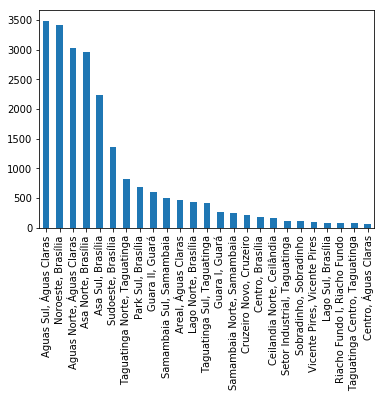

In [15]:
df.bairro.value_counts()[:25].plot.bar()

### Remove bairros com menos imóveis (pega so 25 +)

In [16]:
df.bairro.value_counts()[25:]

Setor De Clubes Esportivos Norte, Brasília                   64
Quadras Economicas Lucio Costa, Guará                        63
Octogonal, Brasília                                          57
Nucleo Bandeirante, Núcleo Bandeirante                       55
Águas Claras, Distrito Federal                               39
Setor Industrial, Gama                                       38
QE Lucio Costa, Guará                                        38
Grande Colorado, Sobradinho                                  38
Centro, Taguatinga                                           38
Setor Central, Gama                                          37
Setor Nova Suiça, Goiânia                                    36
Setor Bela Vista, Goiânia                                    35
Setor Pedro Ludovico, Goiânia                                32
Ceilandia Sul, Ceilândia                                     32
Setor Leste Universitário, Goiânia                           31
Samambaia, Samambaia                    

In [17]:
bairros_reject = df.bairro.value_counts()[25:].index.values
bairros_reject

array(['Setor De Clubes Esportivos Norte, Brasília',
       'Quadras Economicas Lucio Costa, Guará', 'Octogonal, Brasília',
       'Nucleo Bandeirante, Núcleo Bandeirante',
       'Águas Claras, Distrito Federal', 'Setor Industrial, Gama',
       'QE Lucio Costa, Guará', 'Grande Colorado, Sobradinho',
       'Centro, Taguatinga', 'Setor Central, Gama',
       'Setor Nova Suiça, Goiânia', 'Setor Bela Vista, Goiânia',
       'Setor Pedro Ludovico, Goiânia', 'Ceilandia Sul, Ceilândia',
       'Setor Leste Universitário, Goiânia', 'Samambaia, Samambaia',
       'Alto da Glória, Goiânia', 'Turista I, Caldas Novas',
       'Setor Central, Goiânia',
       'Parque Esplanada III, Valparaíso de Goiás',
       'Riacho Fundo, Riacho Fundo', 'Zona Industrial, Guará',
       'Setor de Hotéis e Turismo Norte, Brasília',
       'Cruzeiro Velho, Cruzeiro', 'Superquadra Noroeste, Brasília',
       'Jardim Atlântico, Goiânia',
       'Parque Esplanada II, Valparaíso de Goiás',
       'Residencial Eldora

In [18]:
df = df[~df['bairro'].isin(bairros_reject)]
print(df.shape)
df.head()

(22111, 17)


,nome,valor_venda,url,condominio,IPTU,lat,long,area_total,area_util,banheiros,vagas,quartos,suites,idade,endereco,bairro,idade_anuncio
0,Tower duplex 90m2,550000,https://www.wimoveis.com.br/propriedades/tower...,R$ 730,R$ 690,-15.842635250484830,-48.024645807548495,89m²,89,3.0,2.0,2.0,2.0,6,"Qd 206, Aguas Sul, Águas Claras","Aguas Sul, Águas Claras",52
1,SELECTION 36,2150000,https://www.wimoveis.com.br/propriedades/selec...,NaN,NaN,-15.742129999999999,-47.910919999999997,224m²,224,6.0,3.0,4.0,4.0,4,"Quadra SQNW 110, Noroeste, Brasília","Noroeste, Brasília",6
2,Elevador + Apartamento de 3 Quartos + Excelent...,420000,https://www.wimoveis.com.br/propriedades/eleva...,NaN,NaN,-15.739203900000000,-47.902473900000020,NaN,65,2.0,0.0,3.0,0.0,NaN,SCRN 706/707 BLOCO F - COMPLETO ARMÁRIOS- EXCE...,"Asa Norte, Brasília",9
4,Elegance Park Sul de 03 Suítes,1333800,https://www.wimoveis.com.br/propriedades/elega...,NaN,NaN,-15.827143900000000,-47.952883600000010,117m²,117,5.0,2.0,3.0,3.0,1,"Sgcv 23, Park Sul, Brasília","Park Sul, Brasília",8
5,QI 31 Jardins Life Reformadíssimo Localização ...,580000,https://www.wimoveis.com.br/propriedades/qi-31...,NaN,NaN,-15.840017800000000,-47.975002600000038,NaN,68,2.0,1.0,2.0,1.0,3,"QUADRA QI 31 LOTES 2/4, Guara II, Guará","Guara II, Guará",6


In [19]:
df.bairro.value_counts()

Aguas Sul, Águas Claras          3485
Noroeste, Brasília               3409
Aguas Norte, Águas Claras        3020
Asa Norte, Brasília              2955
Asa Sul, Brasília                2239
Sudoeste, Brasília               1360
Taguatinga Norte, Taguatinga      815
Park Sul, Brasília                690
Guara II, Guará                   605
Samambaia Sul, Samambaia          500
Areal, Águas Claras               465
Lago Norte, Brasília              443
Taguatinga Sul, Taguatinga        422
Guara I, Guará                    261
Samambaia Norte, Samambaia        252
Cruzeiro Novo, Cruzeiro           212
Centro, Brasília                  187
Ceilandia Norte, Ceilândia        167
Setor Industrial, Taguatinga      116
Sobradinho, Sobradinho            108
Vicente Pires, Vicente Pires       96
Lago Sul, Brasília                 79
Riacho Fundo I, Riacho Fundo       78
Taguatinga Centro, Taguatinga      76
Centro, Águas Claras               71
Name: bairro, dtype: int64

In [20]:
df.quartos = df.quartos.fillna(df.quartos.median())

In [21]:
#df_regression = df[['bairro', 'area_util', 'quartos','valor_venda','lat','long',]]
#df_regression = df[['area_util', 'quartos','valor_venda','lat','long','idade_anuncio']]
df_regression = df[['area_util', 'quartos','valor_venda','lat','long']]
print(df_regression.shape)
df_regression.head()

(22111, 5)


,area_util,quartos,valor_venda,lat,long
0,89,2.0,550000,-15.842635250484830,-48.024645807548495
1,224,4.0,2150000,-15.742129999999999,-47.910919999999997
2,65,3.0,420000,-15.739203900000000,-47.902473900000020
4,117,3.0,1333800,-15.827143900000000,-47.952883600000010
5,68,2.0,580000,-15.840017800000000,-47.975002600000038


In [22]:
df_regression.isna().sum()

area_util      0
quartos        0
valor_venda    0
lat            0
long           0
dtype: int64

In [23]:
df_regression.head()

,area_util,quartos,valor_venda,lat,long
0,89,2.0,550000,-15.842635250484830,-48.024645807548495
1,224,4.0,2150000,-15.742129999999999,-47.910919999999997
2,65,3.0,420000,-15.739203900000000,-47.902473900000020
4,117,3.0,1333800,-15.827143900000000,-47.952883600000010
5,68,2.0,580000,-15.840017800000000,-47.975002600000038


In [24]:
#one_hot = pd.get_dummies(df_regression['bairro'], prefix="bairro")
#df_regression = df_regression.join(one_hot)

#df_regression = df_regression.drop(['bairro'], axis=1)

#df_regression.shape
#df_regression.head()

In [25]:
df_regression = df_regression.apply(pd.to_numeric)
#, errors='coerce'
df_regression.dtypes

area_util        int64
quartos        float64
valor_venda      int64
lat            float64
long           float64
dtype: object

In [26]:
#zscore
#mean = df_regression.mean(axis=0)
#std = df_regression.std(axis=0)

# zscore normalization
#df_regression = ( df_regression - mean ) / std

In [27]:
X = df_regression.drop(['valor_venda'],axis=1)
y = df_regression['valor_venda']
X.shape, y.shape

((22111, 4), (22111,))

In [28]:
#X_columns = X.columns.values
#X = pd.DataFrame(StandardScaler().fit_transform(X),columns=X_columns)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19899, 4), (2212, 4), (19899,), (2212,))

In [30]:
reg = RandomForestRegressor(n_estimators=100) 
reg

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [31]:
reg.fit(X_train, y_train)
train_predict = reg.predict(X_train)
test_predict = reg.predict(X_test)

In [32]:
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, test_predict))

rmse = math.sqrt(mean_squared_error(y_test, test_predict))
print("Root Mean squared error: %.2f" % rmse)

print('R2 score: %.2f' % r2_score(y_test, test_predict))

Mean squared error: 32168346136.15
Root Mean squared error: 179355.36
R2 score: 0.92


Feature ranking:
1. feature area_util (0.751539)
2. feature long (0.125753)
3. feature lat (0.116024)
4. feature quartos (0.006684)


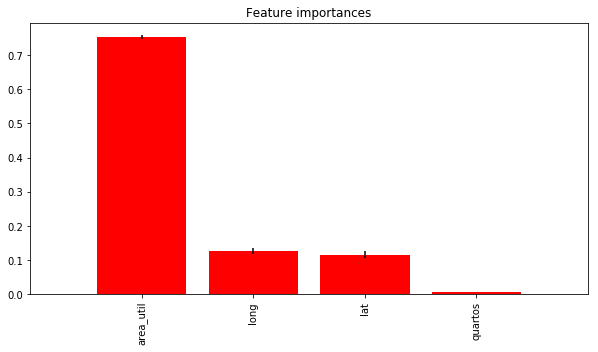

In [33]:
 plt.rcParams['figure.figsize'] = [10, 5]
importances = reg.feature_importances_
std = np.std([tree.feature_importances_ for tree in reg.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

#Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):

    print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [34]:
#reg2 = RandomForestRegressor(n_estimators=100) 

#visualizer = ResidualsPlot(reg2)
#visualizer.fit(X_train, y_train)  # Fit the training data to the model
#visualizer.score(X_test, y_test)  # Evaluate the model on the test data
#visualizer.poof()                 # Draw/show/poof the data

### TODO: scatterplot valor_venda x area util

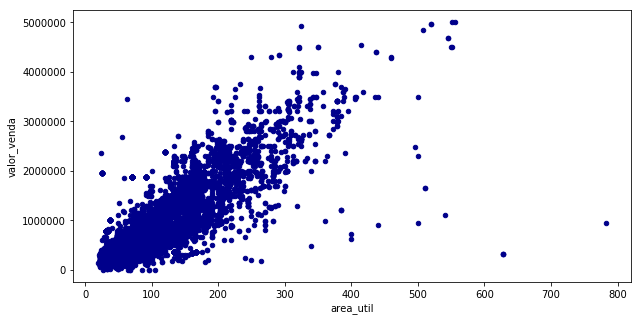

In [35]:

ax1 = df.plot.scatter(x='area_util',
                       y='valor_venda',
                       c='DarkBlue')

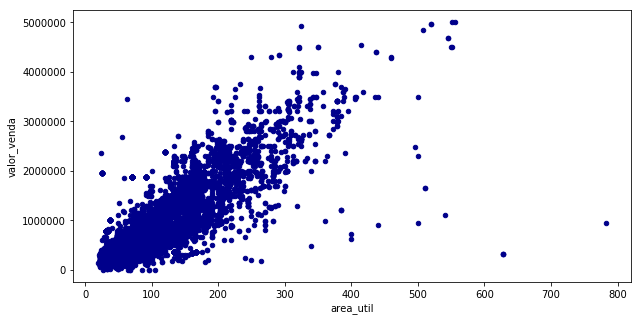

In [36]:
df_zoom = df.loc[df.area_util < 2001]
ax2 = df_zoom.plot.scatter(x='area_util',
                       y='valor_venda',
                       c='DarkBlue')

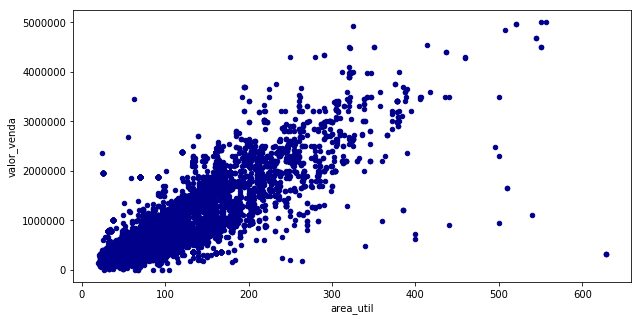

In [37]:
df_zoom = df.loc[df.area_util < 751]
ax2 = df_zoom.plot.scatter(x='area_util',
                       y='valor_venda',
                       c='DarkBlue')

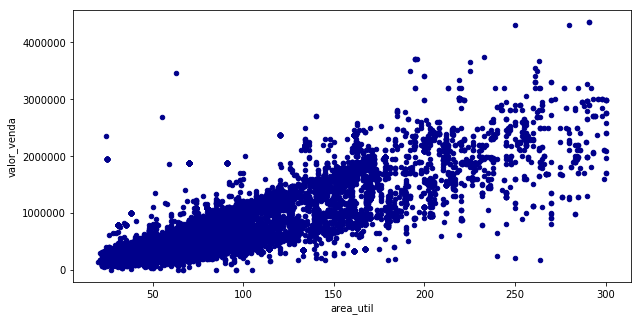

In [38]:
df_zoom = df.loc[df.area_util < 301]
ax2 = df_zoom.plot.scatter(x='area_util',
                       y='valor_venda',
                       c='DarkBlue')

(21890, 17)


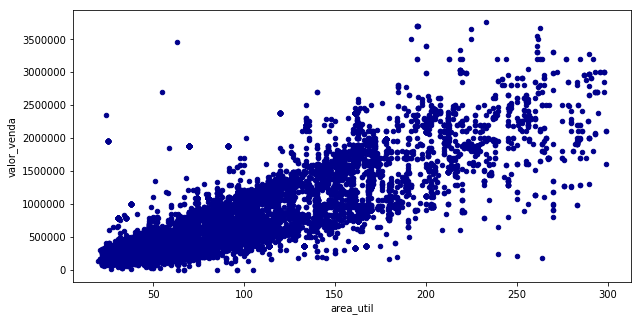

In [39]:
df_zoom = df.loc[(df.area_util < 300) & (df.valor_venda < 4000000)]
print(df_zoom.shape)
ax2 = df_zoom.plot.scatter(x='area_util',
                       y='valor_venda',
                       c='DarkBlue')

(13693, 17)


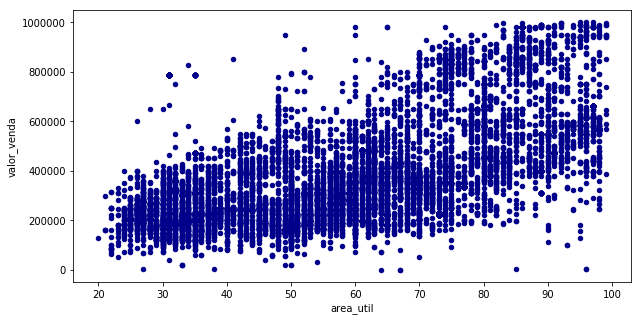

In [40]:
df_zoom = df.loc[(df.area_util < 100) & (df.valor_venda < 1000000)]
print(df_zoom.shape)
ax2 = df_zoom.plot.scatter(x='area_util',
                       y='valor_venda',
                       c='DarkBlue')

In [42]:

lat = -15.752353
long = -47.8830672
area = 87
quartos = 3.0

apto_411_n = [[area,quartos,lat,long]]

previsao = reg.predict(apto_411_n)[0]

correcao = previsao * 0.21
print("previsao de preço: ", previsao -  correcao)

previsao de preço:  592607.44


In [43]:

lat = -15.738213539123535
long = -47.897647857666015
area = 89
quartos = 3.0

apto_316_n = [[area,quartos,lat,long]]

previsao = reg.predict(apto_316_n)[0]

correcao = previsao * 0.21
print("previsao de preço: ", previsao -  correcao)

previsao de preço:  619790.55
